# Model Builiding And Evaluation

- Using Gensim and Scikit Learn

In [ ]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,mlxtend,omegaconf --conda

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.26.0

numpy    : 1.26.0
pandas   : 2.2.2
polars   : 1.4.1
mlxtend  : 0.23.1
omegaconf: not installed

conda environment: n/a



In [ ]:
# Built-in library
from pathlib import Path
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")


# auto reload imports# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(500)

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

### Load Data

In [3]:
pl.Config.set_fmt_str_lengths(20)
pl.set_random_seed(seed=123)


fp: str = "../data/articles_final_df.parquet"
articles_df: pl.DataFrame = pl.read_parquet(fp)
print(f"{articles_df.shape = }")
articles_df.head(2)

articles_df.shape = (9335, 10)


articleID,articleWordCount,documentType,pubDate,source,typeOfMaterial,metadata,metadata_1,metadata_2,is_high_engagement
str,i64,str,date,str,str,str,str,str,u8
"""58927e0495d0e0392607…",1129,"""article""",2017-02-02,"""The New York Times""","""news""","""ken belson n f l vs …","""ken belson n f l vs …","""ken belson n f l vs …",0
"""5893033d95d0e0392607…",3082,"""article""",2017-02-02,"""The New York Times""","""news""","""unknown voice vice v…","""unknown voice vice v…","""unknown voice vice v…",1


In [4]:
data_df: pl.DataFrame = articles_df.select(
    ["articleID", "articleWordCount", "pubDate", "metadata_2", "is_high_engagement"]
).rename({"metadata_2": "text", "is_high_engagement": "label"})

data_df.head()

articleID,articleWordCount,pubDate,text,label
str,i64,date,str,u8
"""58927e0495d0e0392607…",1129,2017-02-02,"""ken belson n f l vs …",0
"""5893033d95d0e0392607…",3082,2017-02-02,"""unknown voice vice v…",1
"""5893039595d0e0392607…",693,2017-02-02,"""manohla dargis a sta…",0
"""5893109995d0e0392607…",1049,2017-02-02,"""alexandra s levine n…",0
"""5893114495d0e0392607…",1283,2017-02-02,"""bonnie tsui a swimme…",0


### Train A Model For Text Vectorization

- We can train a doc22vec or Fastext model to vectorize the text.
- Since the document is quite wordy, we'll  use the doc2vec model.
- FastText provides high-quality word embeddings that capture semantic and syntactic relationships and is suitable for tasks like word similarity, text classification, and language modeling.

In [5]:
from typing import List, Union, Iterator, Tuple, Generator
import gensim
from gensim.models.doc2vec import TaggedDocument
import polars as pl
import logging


def extract_tokens(
    data: pl.DataFrame | pl.LazyFrame,
    min_len: int = 2,
    max_len: int = 15,
) -> Generator[List[str], None, None]:
    """
    Extract tokens from the given DataFrame or LazyFrame.

    Parameters
    ----------
    data : pl.DataFrame | pl.LazyFrame
        Input data containing a 'text' column.
    min_len : int, optional
        Minimum length of tokens to keep, by default 2.
    max_len : int, optional
        Maximum length of tokens to keep, by default 15.

    Yields
    ------
    List[str]
        A list of tokens for each row in the input data.
    """
    if isinstance(data, pl.LazyFrame):
        data = data.collect()
    # Process each row lazily
    for idx, line in enumerate(data.iter_rows(named=True)):
        text: str = line["text"]
        # Convert a document into a list of lowercase tokens
        tokens: List[str] = gensim.utils.simple_preprocess(
            text, min_len=min_len, max_len=max_len
        )
        yield tokens


def read_corpus_file(
    filename: str, min_len: int = 2, max_len: int = 15
) -> Generator[List[str], None, None]:
    """
    Read a corpus file and extract tokens from its contents.

    Parameters
    ----------
    filename : str
        The path to the corpus file.
    min_len : int, optional
        Minimum length of tokens to keep, by default 2.
    max_len : int, optional
        Maximum length of tokens to keep, by default 15.

    Returns
    -------
    Generator[List[str], None, None]
        A generator that yields lists of tokens for each row in the input file.

    Raises
    ------
    Exception
        If there's an error reading the file.
    """
    # Determine file format based on file extension
    format: str = ".csv" if filename.endswith((".txt", ".csv")) else ".parquet"

    try:
        # Read data using polars
        data: pl.LazyFrame = (
            pl.scan_csv(filename) if format == ".csv" else pl.scan_parquet(filename)
        )
    except Exception as e:
        logging.error(f"Error reading file {filename}: {e}")
        return

    # Process each row lazily
    return extract_tokens(data=data, min_len=min_len, max_len=max_len)


def read_corpus_df(
    data: pl.DataFrame, min_len: int = 2, max_len: int = 15
) -> Generator[List[str], None, None]:
    """
    Process a DataFrame and extract tokens from its contents.

    Parameters
    ----------
    data : pl.DataFrame
        The input DataFrame containing text data.
    min_len : int, optional
        Minimum length of tokens to keep, by default 2.
    max_len : int, optional
        Maximum length of tokens to keep, by default 15.

    Returns
    -------
    Generator[List[str], None, None]
        A generator that yields lists of tokens for each row in the input DataFrame.
    """
    # Process each row lazily
    return extract_tokens(data=data, min_len=min_len, max_len=max_len)


def stream_corpus(
    corpus_size: int,
    filename: str | None = None,
    data: pl.DataFrame | None = None,
    min_len: int = 2,
    max_len: int = 15,
) -> list[list[str]]:
    """
    Stream a corpus of tokens from either a file or a DataFrame.

    Parameters
    ----------
    corpus_size : int
        The number of items to stream from the corpus.
    filename : str | None, optional
        The name of the file to read from, by default None.
    data : pl.DataFrame | None, optional
        The DataFrame to read from, by default None.
    min_len : int, optional
        The minimum length of tokens to keep, by default 2.
    max_len : int, optional
        The maximum length of tokens to keep, by default 15.

    Returns
    -------
    list[list[str]]
        A list of token lists, where each inner list represents a set of tokens.

    Raises
    ------
    ValueError
        If neither filename nor data is specified, or if both are specified.
    """
    if filename is None and data is None:
        raise ValueError("Either filename or data must be specified")
    if filename is not None and data is not None:
        raise ValueError("Only one of filename or data must be specified")

    if filename is not None:
        #  Process the data lazily using an iterator.
        corpus_iterator: Generator[list[str], None, None] = read_corpus_file(
            filename, min_len, max_len
        )
    else:
        #  Process the data lazily using an iterator.
        corpus_iterator: Generator[list[str], None, None] = read_corpus_df(
            data, min_len, max_len
        )
    tokens: list[list[str]] = []
    try:
        for _, item in zip(range(corpus_size), corpus_iterator):
            tokens.append(item)

    except StopIteration:
        logging.warning(f"Corpus is smaller than expected size {corpus_size}")

    return tokens

In [6]:
seed: int = 123

total_size: int = data_df.shape[0]
train_size: int = int(total_size * 0.85)
test_size: int = int(total_size * 0.15)

train_df: pl.DataFrame = data_df.sample(n=train_size, seed=seed)
test_df: pl.DataFrame = data_df.sample(n=test_size, seed=seed)

print(f"{train_df.shape = }\n {test_df.shape = }")

train_df.shape = (7934, 5)
 test_df.shape = (1400, 5)


In [8]:
min_len: int = 2  # minimum length of tokens
max_len: int = 15  # maximum length of tokens

train_corpus: list[TaggedDocument] = stream_corpus(
    data=train_df, corpus_size=train_size, min_len=min_len, max_len=max_len
)
test_corpus: tuple[list[str]] = stream_corpus(
    data=test_df, corpus_size=test_size, min_len=min_len, max_len=max_len
)

In [10]:
data_df.head()

articleID,articleWordCount,pubDate,text,label
str,i64,date,str,u8
"""58927e0495d0e0392607…",1129,2017-02-02,"""ken belson n f l vs …",0
"""5893033d95d0e0392607…",3082,2017-02-02,"""unknown voice vice v…",1
"""5893039595d0e0392607…",693,2017-02-02,"""manohla dargis a sta…",0
"""5893109995d0e0392607…",1049,2017-02-02,"""alexandra s levine n…",0
"""5893114495d0e0392607…",1283,2017-02-02,"""bonnie tsui a swimme…",0


In [11]:
from sklearn.model_selection import train_test_split


test_size: float = 0.15
target: str = "label"

# X: pl.DataFrame = articles_df.drop([target])
X: pl.DataFrame = data_df.drop([target])
y: pl.Series = data_df[target]

X_train: pl.DataFrame
y_train: pl.Series
X_test: pl.DataFrame
y_test: pl.Series
X_val: pl.DataFrame
y_val: pl.Series

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=seed, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=test_size, random_state=seed, stratify=y_train
)

print(f"{X_train.shape = }, {X_val.shape = }, {X_test.shape = }")

X_train.shape = (6743, 4), X_val.shape = (1191, 4), X_test.shape = (1401, 4)


In [12]:
y.value_counts(sort=True), y_train.value_counts(sort=True)

(shape: (2, 2)
 ┌───────┬───────┐
 │ label ┆ count │
 │ ---   ┆ ---   │
 │ u8    ┆ u32   │
 ╞═══════╪═══════╡
 │ 0     ┆ 5587  │
 │ 1     ┆ 3748  │
 └───────┴───────┘,
 shape: (2, 2)
 ┌───────┬───────┐
 │ label ┆ count │
 │ ---   ┆ ---   │
 │ u8    ┆ u32   │
 ╞═══════╪═══════╡
 │ 0     ┆ 4036  │
 │ 1     ┆ 2707  │
 └───────┴───────┘)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from opinion_mine.ml.training import (
    calculate_class_weights,
    train_model_with_cross_validation,
)
from spacy.lang.en.stop_words import STOP_WORDS


stopwords: list[str] = list(STOP_WORDS)
n_samples_0: int = np.bincount(y_train.to_numpy())[0]
n_samples_1: int = np.bincount(y_train.to_numpy())[1]
total_samples: int = y_train.shape[0]
n_classes: int = len(np.unique(y_train))

weight_0: float = calculate_class_weights(
    n_samples=n_samples_0, total_samples=total_samples, n_classes=n_classes
)
weight_1: float = calculate_class_weights(
    n_samples=n_samples_1, total_samples=total_samples, n_classes=n_classes
)

class_weight: dict[str, float] = {0: weight_0, 1: weight_1}
print(f"{class_weight = }")

class_weight = {0: 0.8354, 1: 1.2455}


In [14]:
# One-hot encode
ohe_columns: list[str] = ["year"]

# Others
text_columns: list[str] = ["text"]
numeric_columns: list[str] = ["articleWordCount"]
date_columns: list[str] = ["pubDate"]
cyclical_columns: list[str] = ["day", "day_of_week", "week_of_year", "month"]

# Columns to drop
drop_columns: list[str] = [
    "pubDate",
    "day",
    "day_of_week",
    "month",
    "week_of_year",
    "day_cos",
    "day_sin",
    "quarter",
]

In [15]:
from sklearn.pipeline import Pipeline

from opinion_mine.ml.transformers import (
    CustomOneHotEncoder,
    CyclicTemporalFeatures,
    DropFeatures,
    ExtractTemporalFeatures,
    NumericalScaler,
    SVDTransformer,
    TFIDFTransformer,
    GensimTFIDFTransformer,
    GensimLSITransformer,
)
from opinion_mine.ml.evaluation import *


max_df: float = 0.95
min_df: float = 2
n_components: int = 300


preprocessor_pipe: Pipeline = Pipeline(
    steps=[
        (
            "temporal_features",
            ExtractTemporalFeatures(
                date_column="pubDate", date_format="%Y-%m-%d %H:%M:%S"
            ),
        ),
        ("cyclical_features", CyclicTemporalFeatures()),
        ("ohe", CustomOneHotEncoder(features=ohe_columns)),
        ("tfidf_vectorizer", GensimTFIDFTransformer(feature="text")),
        (
            "lsi_vectorizer",
            GensimLSITransformer(
                include_pattern="tfidf__*", num_topics=n_components, random_state=seed
            ),
        ),
        ("drop_features", DropFeatures(features=drop_columns)),
        (
            "scaler",
            NumericalScaler(scaler_type="min_max", exclude_features=["articleID"]),
        ),
        ("drop_features_2", DropFeatures(features=["articleID"])),
    ]
)

preprocessor_pipe

Pipeline(steps=[('temporal_features',
                 ExtractTemporalFeatures(date_column='pubDate')),
                ('cyclical_features', CyclicTemporalFeatures()),
                ('ohe', CustomOneHotEncoder(features=['year'])),
                ('tfidf_vectorizer', GensimTFIDFTransformer(feature='text')),
                ('lsi_vectorizer',
                 GensimLSITransformer(include_pattern='tfidf__*',
                                      num_topics=300, random_state=123)),
                ('drop_features',
                 DropFeatures(features=['pubDate', 'day', 'day_of_week',
                                        'month', 'week_of_year', 'day_cos',
                                        'day_sin', 'quarter'])),
                ('scaler',
                 NumericalScaler(exclude_features=['articleID'],
                                 scaler_type='min_max')),
                ('drop_features_2', DropFeatures(features=['articleID']))])

In [16]:
X_train_tr: pl.DataFrame = preprocessor_pipe.fit_transform(X_train)
X_test_tr: pl.DataFrame = preprocessor_pipe.transform(X_test)
X_val_tr: pl.DataFrame = preprocessor_pipe.transform(X_val)


print(f"{X_train_tr.shape = }, {X_test_tr.shape = }, {X_val_tr.shape = }")

X_train_tr.shape = (6743, 309), X_test_tr.shape = (1401, 309), X_val_tr.shape = (1191, 309)


In [17]:
X_train_tr.head(2)

articleWordCount,day_of_week_cos,day_of_week_sin,lsi__0,lsi__1,lsi__10,lsi__100,lsi__101,lsi__102,lsi__103,lsi__104,lsi__105,lsi__106,lsi__107,lsi__108,lsi__109,lsi__11,lsi__110,lsi__111,lsi__112,lsi__113,lsi__114,lsi__115,lsi__116,lsi__117,lsi__118,lsi__119,lsi__12,lsi__120,lsi__121,lsi__122,lsi__123,lsi__124,lsi__125,lsi__126,lsi__127,lsi__128,lsi__129,lsi__13,lsi__130,lsi__131,lsi__132,lsi__133,lsi__134,lsi__135,lsi__136,lsi__137,lsi__138,lsi__139,lsi__14,lsi__140,lsi__141,lsi__142,lsi__143,lsi__144,lsi__145,lsi__146,lsi__147,lsi__148,lsi__149,lsi__15,lsi__150,lsi__151,lsi__152,lsi__153,lsi__154,lsi__155,lsi__156,lsi__157,lsi__158,lsi__159,lsi__16,lsi__160,lsi__161,lsi__162,lsi__163,lsi__164,lsi__165,lsi__166,lsi__167,lsi__168,lsi__169,lsi__17,lsi__170,lsi__171,lsi__172,lsi__173,lsi__174,lsi__175,lsi__176,lsi__177,lsi__178,lsi__179,lsi__18,lsi__180,lsi__181,lsi__182,lsi__183,lsi__184,lsi__185,lsi__186,lsi__187,lsi__188,lsi__189,lsi__19,lsi__190,lsi__191,lsi__192,lsi__193,lsi__194,lsi__195,lsi__196,lsi__197,lsi__198,lsi__199,lsi__2,lsi__20,lsi__200,lsi__201,lsi__202,lsi__203,lsi__204,lsi__205,lsi__206,lsi__207,lsi__208,lsi__209,lsi__21,lsi__210,lsi__211,lsi__212,lsi__213,lsi__214,lsi__215,lsi__216,lsi__217,lsi__218,lsi__219,lsi__22,lsi__220,lsi__221,lsi__222,lsi__223,lsi__224,lsi__225,lsi__226,lsi__227,lsi__228,lsi__229,lsi__23,lsi__230,lsi__231,lsi__232,lsi__233,lsi__234,lsi__235,lsi__236,lsi__237,lsi__238,lsi__239,lsi__24,lsi__240,lsi__241,lsi__242,lsi__243,lsi__244,lsi__245,lsi__246,lsi__247,lsi__248,lsi__249,lsi__25,lsi__250,lsi__251,lsi__252,lsi__253,lsi__254,lsi__255,lsi__256,lsi__257,lsi__258,lsi__259,lsi__26,lsi__260,lsi__261,lsi__262,lsi__263,lsi__264,lsi__265,lsi__266,lsi__267,lsi__268,lsi__269,lsi__27,lsi__270,lsi__271,lsi__272,lsi__273,lsi__274,lsi__275,lsi__276,lsi__277,lsi__278,lsi__279,lsi__28,lsi__280,lsi__281,lsi__282,lsi__283,lsi__284,lsi__285,lsi__286,lsi__287,lsi__288,lsi__289,lsi__29,lsi__290,lsi__291,lsi__292,lsi__293,lsi__294,lsi__295,lsi__296,lsi__297,lsi__298,lsi__299,lsi__3,lsi__30,lsi__31,lsi__32,lsi__33,lsi__34,lsi__35,lsi__36,lsi__37,lsi__38,lsi__39,lsi__4,lsi__40,lsi__41,lsi__42,lsi__43,lsi__44,lsi__45,lsi__46,lsi__47,lsi__48,lsi__49,lsi__5,lsi__50,lsi__51,lsi__52,lsi__53,lsi__54,lsi__55,lsi__56,lsi__57,lsi__58,lsi__59,lsi__6,lsi__60,lsi__61,lsi__62,lsi__63,lsi__64,lsi__65,lsi__66,lsi__67,lsi__68,lsi__69,lsi__7,lsi__70,lsi__71,lsi__72,lsi__73,lsi__74,lsi__75,lsi__76,lsi__77,lsi__78,lsi__79,lsi__8,lsi__80,lsi__81,lsi__82,lsi__83,lsi__84,lsi__85,lsi__86,lsi__87,lsi__88,lsi__89,lsi__9,lsi__90,lsi__91,lsi__92,lsi__93,lsi__94,lsi__95,lsi__96,lsi__97,lsi__98,lsi__99,month_cos,month_sin,week_of_year_cos,week_of_year_sin,year_2017,year_2018
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.053829,5.5511e-17,0.722521,0.140521,0.300091,0.64

In [18]:
# # import TruncatedSVD
# from sklearn.decomposition import TruncatedSVD


# svd: TruncatedSVD = preprocessor_pipe.named_steps["svd"]

# plot_cumulative_variance(estimator=svd)

In [19]:
log_model: LogisticRegression = LogisticRegression(
    class_weight=class_weight,
    random_state=seed,
)
rf_model: RandomForestClassifier = RandomForestClassifier(
    n_estimators=50,
    class_weight=class_weight,
    random_state=seed,
    max_depth=10,
)

In [20]:
log_model, scores, mean_accuracy, std_accuracy = train_model_with_cross_validation(
    X=X_train_tr, y=y_train, estimator=log_model, n_splits=5
)

Fold:  1 | Class dist.: [3228 2166] | Acc: 0.755
Fold:  2 | Class dist.: [3229 2165] | Acc: 0.757
Fold:  3 | Class dist.: [3229 2165] | Acc: 0.765
Fold:  4 | Class dist.: [3229 2166] | Acc: 0.760
Fold:  5 | Class dist.: [3229 2166] | Acc: 0.757

CV accuracy: 0.759 +/- 0.003

Time taken: 1.051 seconds


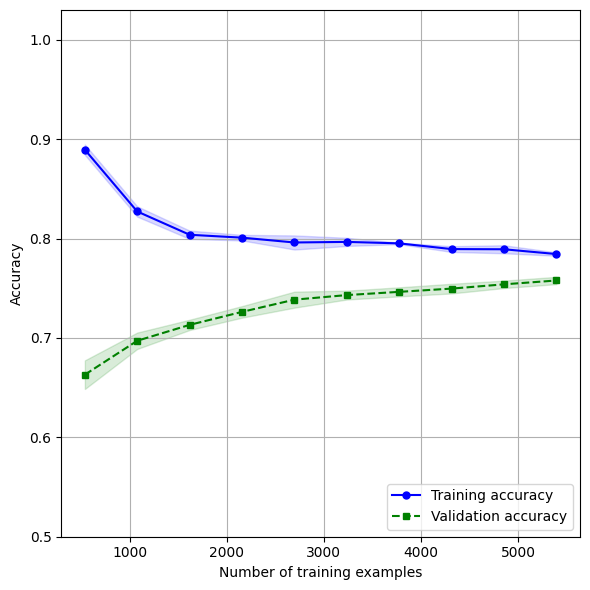

In [21]:
plot_learning_curve(
    estimator=log_model,
    X=X_train_tr,
    y=y_train,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=5,
)

In [22]:
y_train_pred: np.ndarray = log_model.predict(X_train_tr)
y_train_proba: np.ndarray = log_model.predict_proba(X_train_tr)[:, 1]

y_test_pred: np.ndarray = log_model.predict(X_test_tr)
y_test_proba: np.ndarray = log_model.predict_proba(X_test_tr)[:, 1]

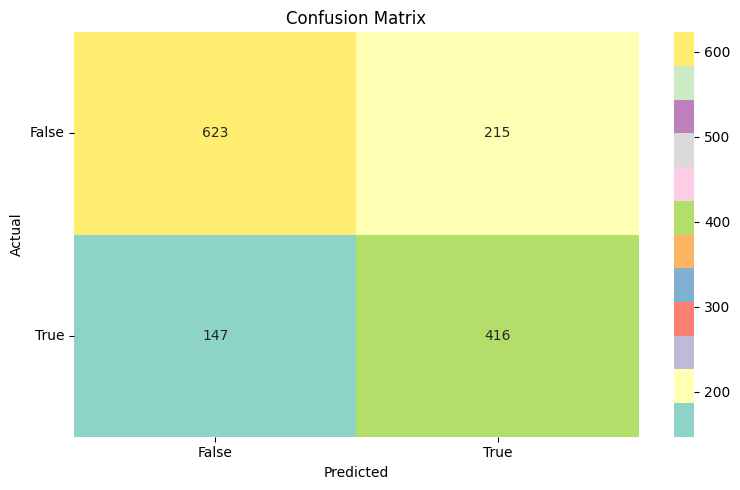

In [23]:
plot_confusion_matrix(y_true=y_test, y_pred=y_test_pred, labels=["False", "True"])

In [24]:
from sklearn import metrics

# === ROC AUC ===
# Shape: (n_samples, n_classes)[:, 1] -> (n_samples, )


train_auc_score: float = metrics.roc_auc_score(y_true=y_train, y_score=y_train_proba)
test_auc_score: float = metrics.roc_auc_score(y_true=y_test, y_score=y_test_proba)

print(f"Train AUC Score: {train_auc_score:.4f}\nTest AUC Score: {test_auc_score:.4f}")

Train AUC Score: 0.8583
Test AUC Score: 0.8210


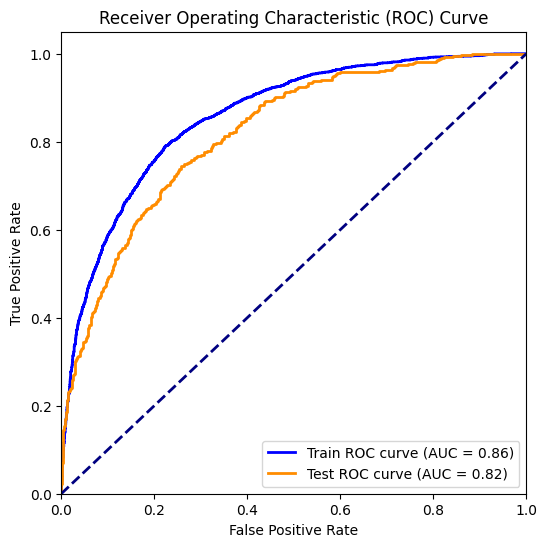

In [25]:
plot_roc_curves(
    y_train,
    y_train_proba,
    y_test,
    y_test_proba,
)

### Random Forest

In [26]:
rf_model, scores, mean_accuracy, std_accuracy = train_model_with_cross_validation(
    X=X_train_tr, y=y_train, estimator=rf_model, n_splits=5
)

Fold:  1 | Class dist.: [3228 2166] | Acc: 0.746
Fold:  2 | Class dist.: [3229 2165] | Acc: 0.748
Fold:  3 | Class dist.: [3229 2165] | Acc: 0.741
Fold:  4 | Class dist.: [3229 2166] | Acc: 0.746
Fold:  5 | Class dist.: [3229 2166] | Acc: 0.740

CV accuracy: 0.744 +/- 0.003

Time taken: 23.516 seconds


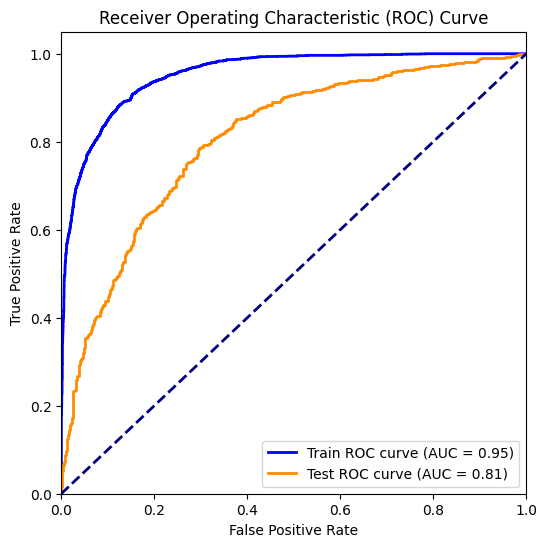

In [27]:
y_train_pred: np.ndarray = rf_model.predict(X_train_tr)
y_train_proba: np.ndarray = rf_model.predict_proba(X_train_tr)[:, 1]

y_test_pred: np.ndarray = rf_model.predict(X_test_tr)
y_test_proba: np.ndarray = rf_model.predict_proba(X_test_tr)[:, 1]


plot_roc_curves(
    y_train,
    y_train_proba,
    y_test,
    y_test_proba,
)

In [28]:
# === ROC AUC ===
# Shape: (n_samples, n_classes)[:, 1] -> (n_samples, )
train_auc_score: float = metrics.roc_auc_score(y_true=y_train, y_score=y_train_proba)
test_auc_score: float = metrics.roc_auc_score(y_true=y_test, y_score=y_test_proba)

print(f"Train AUC Score: {train_auc_score:.4f}\nTest AUC Score: {test_auc_score:.4f}")

Train AUC Score: 0.9534
Test AUC Score: 0.8066


### Voting Classifier

In [29]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score


voting_clf: VotingClassifier = VotingClassifier(
    estimators=[("log_model", log_model), ("rf_model", rf_model)],
    voting="soft",
    weights=[0.6, 0.4],
)
clf_labels: list[str] = ["Logistic Regression Clf", "Random Forest Clf", "Voting Clf"]
all_clf: list[Any] = [log_model, rf_model, voting_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(
        estimator=clf, X=X_train_tr, y=y_train, cv=5, scoring="roc_auc"
    )
    print(f"ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")

ROC AUC: 0.83 (+/- 0.00) [Logistic Regression Clf]
ROC AUC: 0.82 (+/- 0.01) [Random Forest Clf]
ROC AUC: 0.84 (+/- 0.00) [Voting Clf]


In [30]:
voting_clf, _, _, _ = train_model_with_cross_validation(
    X_train_tr, y_train, estimator=voting_clf, n_splits=5
)

Fold:  1 | Class dist.: [3228 2166] | Acc: 0.764
Fold:  2 | Class dist.: [3229 2165] | Acc: 0.771
Fold:  3 | Class dist.: [3229 2165] | Acc: 0.760
Fold:  4 | Class dist.: [3229 2166] | Acc: 0.761
Fold:  5 | Class dist.: [3229 2166] | Acc: 0.759

CV accuracy: 0.763 +/- 0.004

Time taken: 23.965 seconds


In [31]:
# === ROC AUC ===
# Shape: (n_samples, n_classes)[:, 1] -> (n_samples, )
voting_clf: VotingClassifier

y_proba_train: np.ndarray = voting_clf.predict_proba(X_train_tr)[:, 1]
y_proba_test: np.ndarray = voting_clf.predict_proba(X_test_tr)[:, 1]


train_auc_score: float = metrics.roc_auc_score(y_true=y_train, y_score=y_proba_train)
test_auc_score: float = metrics.roc_auc_score(y_true=y_test, y_score=y_proba_test)

print(f"Train AUC Score: {train_auc_score:.4f}\nTest AUC Score: {test_auc_score:.4f}")

Train AUC Score: 0.9082
Test AUC Score: 0.8259
